In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_results(file_path):
    """Load results from JSON file"""
    with open(file_path, 'r') as f:
        return json.load(f)

def extract_benchmark_scores(results):
    """Extract key benchmark scores from results"""
    scores = {}
    
    # MMLU Average
    mmlu_avg = results['results'].get('helm|mmlu:_average|5', {})
    scores['MMLU'] = mmlu_avg.get('em', 0)
    
    # GSM8K
    gsm8k = results['results'].get('leaderboard|gsm8k|8', {})
    scores['GSM8K'] = gsm8k.get('qem', 0)
    
    # ARC Challenge
    arc = results['results'].get('leaderboard|arc:challenge|3', {})
    scores['ARC-C'] = arc.get('acc_norm', 0)
    
    # HellaSwag
    hellaswag = results['results'].get('leaderboard|hellaswag|10', {})
    scores['HellaSwag'] = hellaswag.get('acc_norm', 0)
    
    # TruthfulQA MC1
    truthfulqa = results['results'].get('leaderboard|truthfulqa:mc|0', {})
    scores['TruthfulQA-MC1'] = truthfulqa.get('truthfulqa_mc1', 0)
    scores['TruthfulQA-MC2'] = truthfulqa.get('truthfulqa_mc2', 0)
    
    return scores

def create_comparison_plot(base_file, sft_file, save_path=None):
    """Create comparison plot between base and SFT models"""
    
    # Load results
    base_results = load_results(base_file)
    sft_results = load_results(sft_file)
    
    # Extract scores
    base_scores = extract_benchmark_scores(base_results)
    sft_scores = extract_benchmark_scores(sft_results)
    
    # Create DataFrame for easier manipulation
    benchmarks = list(base_scores.keys())
    base_values = [base_scores[b] for b in benchmarks]
    sft_values = [sft_scores[b] for b in benchmarks]
    differences = [sft_values[i] - base_values[i] for i in range(len(benchmarks))]
    
    df = pd.DataFrame({
        'Benchmark': benchmarks,
        'Base': base_values,
        'SFT': sft_values,
        'Difference': differences
    })
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Side-by-side comparison
    x = np.arange(len(benchmarks))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, base_values, width, label='Base Model', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, sft_values, width, label='SFT Model', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Benchmarks')
    ax1.set_ylabel('Score')
    ax1.set_title('Base vs SFT Model Performance')
    ax1.set_xticks(x)
    ax1.set_xticklabels(benchmarks, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Difference plot
    colors = ['green' if d > 0 else 'red' for d in differences]
    bars3 = ax2.bar(benchmarks, differences, color=colors, alpha=0.7)
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Benchmarks')
    ax2.set_ylabel('Score Difference (SFT - Base)')
    ax2.set_title('Performance Change After Fine-tuning')
    ax2.set_xticklabels(benchmarks, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on difference bars
    for bar, diff in zip(bars3, differences):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., 
                height + (0.002 if height >= 0 else -0.008),
                f'{diff:+.3f}', ha='center', 
                va='bottom' if height >= 0 else 'top', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Print summary
    print("Performance Summary:")
    print("=" * 50)
    print(f"{'Benchmark':<15} {'Base':<8} {'SFT':<8} {'Change':<10} {'Status'}")
    print("-" * 50)
    for i, benchmark in enumerate(benchmarks):
        status = "↑ IMPROVED" if differences[i] > 0 else "↓ DEGRADED" if differences[i] < 0 else "→ SAME"
        print(f"{benchmark:<15} {base_values[i]:<8.3f} {sft_values[i]:<8.3f} {differences[i]:+8.3f} {status}")
    
    improved = sum(1 for d in differences if d > 0)
    degraded = sum(1 for d in differences if d < 0)
    print(f"\nSummary: {improved} improved, {degraded} degraded out of {len(benchmarks)} benchmarks")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()
    
    return df

/tmp/ipykernel_4044591/1937530213.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(benchmarks, rotation=45, ha='right')


Performance Summary:
Benchmark       Base     SFT      Change     Status
--------------------------------------------------
MMLU            0.556    0.546      -0.010 ↓ DEGRADED
GSM8K           0.126    0.352      +0.226 ↑ IMPROVED
ARC-C           0.546    0.550      +0.004 ↑ IMPROVED
HellaSwag       0.792    0.804      +0.012 ↑ IMPROVED
TruthfulQA-MC1  0.296    0.310      +0.014 ↑ IMPROVED
TruthfulQA-MC2  0.454    0.451      -0.003 ↓ DEGRADED

Summary: 4 improved, 2 degraded out of 6 benchmarks

Plot saved to: comparison_plot.png


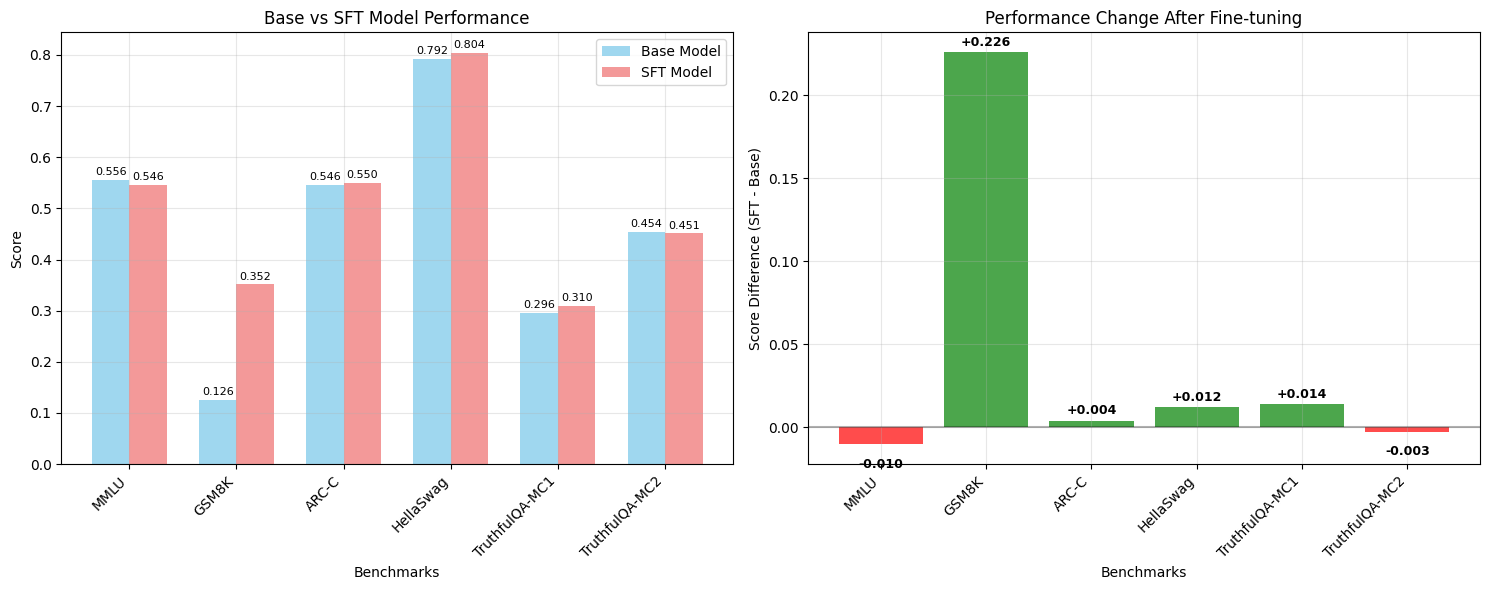

In [3]:
df = create_comparison_plot('/home/markus_frey/Github/modalities/tutorials/instruct_teuken/notebooks/data/basemodel/results_2025-08-22T12-08-14.798298.json',
                             '/home/markus_frey/Github/modalities/tutorials/instruct_teuken/notebooks/data/sft_3e-5_bs1_acc4_70000steps_gsm8k04/results_2025-08-22T12-04-29.938973.json', 'comparison_plot.png')